In [1]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pickle
from utils.shapefiles import sampleShapefileLocations
from analysis.peaksdata import filterPeaksHaversineDist
from utils.divtree_gen import *
from utils.seqdata_gen import *
from utils.seq2demodst import *
# process each region (note: it takes a long time!)
regionShapesDir = 'data/regionShapes'
regionPeaksDir = 'data/regionPeaks'
regionSeqsDir = 'data/regionSeqs'
regionTreeSeqsDir = 'data/regionTreeSeqs'

regionShapes = ['andes_peru.shp']

In [2]:
def drawTree(path):
    x = [v[0][0] for v in path]
    y = [v[1] for v in path]
    X = []
    Y = []
    for i in range(len(path) - 1):
        X.append([path[i][0][0], path[i][1][0]])
        Y.append([path[i][0][1], path[i][1][1]])
    for i in range(len(X)):
        plt.plot(X[i], Y[i], color='g')

andes_peru.shp :  529 samples


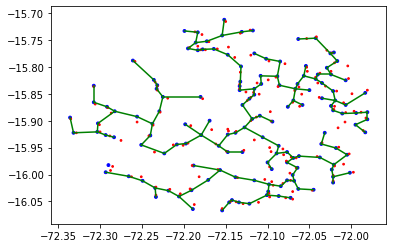

In [4]:

diskRadius = 20
for region in regionShapes:
    st = time.time()
    # sample stats locations inside polygon, separated at least 1/2 radius distance
    sampleLocations = sampleShapefileLocations(os.path.join(regionShapesDir, region), diskRadius)
    print(region, ": ", len(sampleLocations), "samples")
    # region peaks DB
    df = pd.read_csv(os.path.join(regionPeaksDir, region.replace('.shp', '.csv')))
    
    peaks = filterPeaksHaversineDist(df, sampleLocations[0], diskRadius)

    X = []
    Y = []
    sX = []
    sY = []
    for i in peaks.index:
        X.append(peaks['longitude'].loc[i])
        Y.append(peaks['latitude'].loc[i])
        sX.append(peaks['key saddle longitude'].loc[i])
        sY.append(peaks['key saddle latitude'].loc[i])
    ss = [8 for n in range(len(sX))]
    plt.scatter(X, Y, c='b', s=ss)
    ss = [3 for n in range(len(sX))]
    plt.scatter(sX, sY, c='r', s=ss)
    # build the divide trees
    # rootidx = peaks['elevation in feet'].idxmax()
    # peaks['longitude'] -= peaks['longitude'].loc[rootidx]
    # peaks['latitude'] -= peaks['latitude'].loc[rootidx]
    rootNode = genDivideTree(peaks)
    seqOfTree = genFullSeqExample(rootNode, isDFS=False)
    drawTree(seqOfTree)
    plt.show()

## For HMM, sequence representation of peaks

In [ ]:

diskRadius = 20
for region in regionShapes:
    st = time.time()
    # region peaks DB
    peaks = pd.read_csv(os.path.join(regionPeaksDir, region.replace('.shp', '.csv')))
    print(len(peaks))
    rootNode = genDivideTree(peaks)
    seqOfTree = genFullSeqHMM(rootNode, isDFS=False)
    with open(os.path.join(regionTreeSeqsDir, region.replace('.shp', 'HMMBFS.txt')), 'wb') as f:
        pickle.dump(seqOfTree, f)

    seqOfTree = genFullSeqHMM(rootNode, isDFS=True)
    with open(os.path.join(regionTreeSeqsDir, region.replace('.shp', 'HMMDFS.txt')), 'wb') as f:
        pickle.dump(seqOfTree, f)

print('done!')

## For DGMG, sequence representation of node addation and connection

In [8]:

diskRadius = 10
for region in regionShapes:
    st = time.time()
    # sample stats locations inside polygon, separated at least 1/2 radius distance
    sampleLocations = sampleShapefileLocations(os.path.join(regionShapesDir, region), diskRadius)
    print(region, ": ", len(sampleLocations), "samples")
    # region peaks DB
    df = pd.read_csv(os.path.join(regionPeaksDir, region.replace('.shp', '.csv')))

    good = 0

    allTrees = []
    # compute sequences
    for di,diskCenter in tqdm(enumerate(sampleLocations)):
        # filter peaks in disk using haversine distance
        peaks = filterPeaksHaversineDist(df, diskCenter, diskRadius)
        # skip if not enough peaks
        if peaks.shape[0] < 10:
            continue
        good += 1
        # build the divide trees
        rootidx = peaks['elevation in feet'].idxmax()
        peaks['longitude'] -= peaks['longitude'].loc[rootidx]
        peaks['latitude'] -= peaks['latitude'].loc[rootidx]
        
        rootNode = genDivideTree(peaks)
        seqOfTree = genFullSeqDGMG(rootNode, isDFS=False)
        allTrees.append(seqOfTree)
    
    print(good)
    with open(os.path.join(regionTreeSeqsDir, region.replace('.shp', 'DGMGL.txt')), 'wb') as f:
        pickle.dump(allTrees, f)

    print('%s: %3d samples, %3d sequences, %d s'%(region, len(sampleLocations), len(allTrees), time.time() - st)) 

print('done!')

0it [00:00, ?it/s]andes_peru.shp :  2335 samples
2335it [07:19,  5.32it/s]
2304
andes_peru.shp: 2335 samples, 2304 sequences, 441 s
done!


## For RNN, sequence representation of the tree

In [2]:

diskRadius = 20
for region in regionShapes:
    st = time.time()
    # sample stats locations inside polygon, separated at least 1/2 radius distance
    sampleLocations = sampleShapefileLocations(os.path.join(regionShapesDir, region), diskRadius)
    print(region, ": ", len(sampleLocations), "samples")
    # region peaks DB
    df = pd.read_csv(os.path.join(regionPeaksDir, region.replace('.shp', '.csv')))
    print(len(sampleLocations))
    allTrees = []
    # compute sequences
    for di,diskCenter in tqdm(enumerate(sampleLocations)):
        # filter peaks in disk using haversine distance
        peaks = filterPeaksHaversineDist(df, diskCenter, diskRadius)
        # skip if not enough peaks
        if peaks.shape[0] < 10:
            continue
        # build the divide tree
        rootNode = genDivideTree(peaks)
        seqOfTree = genFullSeqRNN(rootNode, isDFS=True)
        allTrees.append(seqOfTree)
    fout = open(os.path.join(regionTreeSeqsDir, region.replace('.shp', 'little.txt')), 'w') 
    for seqTree in allTrees:
        fout.write(",".join( [";".join([str(i) for i in v] ) for v in seqTree]))
        fout.write('\n')
    fout.close()

    print('%s: %3d samples, %3d sequences, %d s'%(region, len(sampleLocations), len(allTrees), time.time() - st)) 

print('done!')

0it [00:00, ?it/s]andes_peru.shp :  526 samples
526
526it [20:48,  2.37s/it]
andes_peru.shp: 526 samples, 526 sequences, 1249 s
done!


## Test, Find max-min for normalization

In [ ]:
for region in regionShapes:
    file_in = open(os.path.join(regionTreeSeqsDir, region.replace('.shp', '.txt')), 'r')
    allpoints = []
    for line in file_in.readlines():
        for s in line.split(','):
            allpoints.append([float(c) for c in s.split(';')])
    allpoints = np.array(allpoints)
    datamax = allpoints.max(axis=0)
    datamin = allpoints.min(axis=0)
    datamean = allpoints.mean(axis=0)
    datastd = allpoints.std(axis=0)
    print(datamax)
    print(datamin)
    print(datamean)
    print(datastd)

## For Demo

In [ ]:


for region in regionShapes:
    st = time.time()
    # sample stats locations inside polygon, separated at least 1/2 radius distance
    sampleLocations = sampleShapefileLocations(os.path.join(regionShapesDir, region), diskRadius)
    print(region, ": ", len(sampleLocations), "samples")
    # region peaks DB
    df = pd.read_csv(os.path.join(regionPeaksDir, region.replace('.shp', '.csv')))

    allSeqs = []
    # compute sequences
    for di,diskCenter in enumerate(sampleLocations):
        # filter peaks in disk using haversine distance
        peaks = filterPeaksHaversineDist(df, diskCenter, diskRadius)
        # skip if not enough peaks
        if peaks.shape[0] < 20:
            continue
        paths = genSeq(peaks)
        seqs = [p for p in paths if len(p) > 10]
        allSeqs += seqs
        # for debug, draw Seqs tree
        # drawSeq(peaks, seqs)
        print('%s: %3d/%3d samples '%(region, di+1, len(sampleLocations)), end='\r' if di+1 < len(sampleLocations) else '\n')
    fout = open(os.path.join(regionSeqsDir, region.replace('.shp', '.txt')), 'w') 
    for s in allSeqs:
        fout.write(" ".join([str(v) for v in s]))
        fout.write('\n')
    fout.close()

    print('%s: %3d samples, %3d sequences, %d s'%(region, len(sampleLocations), len(allSeqs), time.time() - st)) 

print('done!')